# Setup

In [1]:
import os

# use this display function to display DataFrames nicely
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# change the font_scale all at once
sns.set(font_scale=1.5)

# use the ggplot theme for our figures
plt.style.use('ggplot')
# set default figure size
plt.rcParams['figure.figsize'] = (16, 10)

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# check whether your PyTorch has access to GPU
# if you don't, make sure to follow the steps mentioned
#  in the README file.
torch.cuda.is_available()

True

In [3]:
# set up the device to use for our torch tensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
DATA_PATH = os.path.join("data", "career-con-2019")

In [5]:
X_train = pd.read_csv(os.path.join(DATA_PATH, "X_train.csv"))
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [6]:
y_train = pd.read_csv(os.path.join(DATA_PATH, "y_train.csv"))
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


# Training Config

In [7]:
BATCH_SIZE = 64
EPOCHS = 250

# Some Visualizations

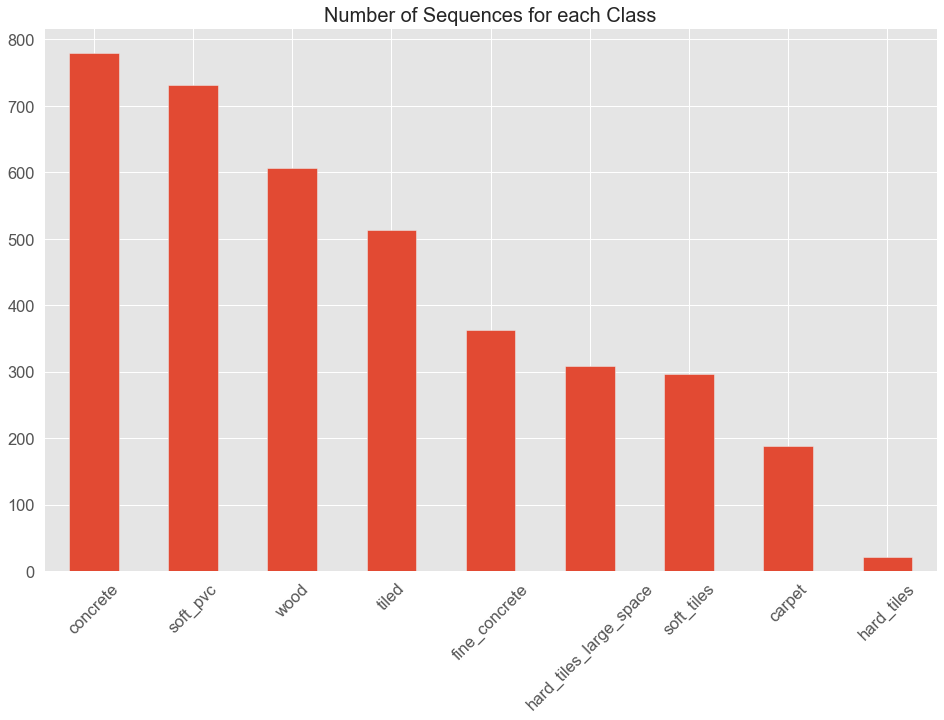

In [8]:
y_train['surface'].value_counts().plot(kind='bar')
plt.title("Number of Sequences for each Class", size=20)
plt.xticks(rotation=45);

# Preprocess the data

In [9]:
# encode the labels into ids
unique_labels = y_train['surface'].unique()
label_name2encoded = {name: idx for idx, name in enumerate(unique_labels)}
label_encoded2name = {idx: name for name, idx in label_name2encoded.items()}

In [10]:
print(label_name2encoded)
print(label_encoded2name)

{'fine_concrete': 0, 'concrete': 1, 'soft_tiles': 2, 'tiled': 3, 'soft_pvc': 4, 'hard_tiles_large_space': 5, 'carpet': 6, 'hard_tiles': 7, 'wood': 8}
{0: 'fine_concrete', 1: 'concrete', 2: 'soft_tiles', 3: 'tiled', 4: 'soft_pvc', 5: 'hard_tiles_large_space', 6: 'carpet', 7: 'hard_tiles', 8: 'wood'}


In [11]:
# get the feature columns
feature_cols = X_train.columns[3:].values
feature_cols

array(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W',
       'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
       'linear_acceleration_X', 'linear_acceleration_Y',
       'linear_acceleration_Z'], dtype=object)

In [12]:
# there are 128 timesteps for each sequence
(X_train.groupby("series_id")['row_id'].count() == 128).all()

True

In [13]:
# create a list of tuples of sequences and encoded labels
sequence_list = []
for series_id, group in X_train.groupby("series_id"):
    sequence = group[feature_cols].values
    label = y_train.loc[y_train['series_id'] == series_id, 'surface'].values[0]
    encoded_label = label_name2encoded[label]
    # append the sequence and label as tuple into the list
    sequence_list.append((sequence, encoded_label))

In [14]:
# showing an example of sequence with its label
sequence_idx = 0
sequence = sequence_list[sequence_idx][0]
label = sequence_list[sequence_idx][1]
print(f"label = {label}")
print(label_encoded2name[label])
print(sequence)

label = 0
fine_concrete
[[ -0.75853  -0.63435  -0.10488 ...  -0.74857   2.103    -9.7532 ]
 [ -0.75853  -0.63434  -0.1049  ...   0.33995   1.5064   -9.4128 ]
 [ -0.75853  -0.63435  -0.10492 ...  -0.26429   1.5922   -8.7267 ]
 ...
 [ -0.75949  -0.63309  -0.10467 ...  -0.98193   0.97328  -9.9795 ]
 [ -0.7595   -0.63307  -0.10464 ...  -0.72591   0.34931 -11.977  ]
 [ -0.75953  -0.63306  -0.10461 ...  -0.53426   0.80346 -10.697  ]]


In [15]:
train_sequences, val_sequences = train_test_split(sequence_list, test_size=0.2)
print(len(train_sequences))
print(len(val_sequences))

3048
762


# Create PyTorch Dataset and DataLoaders

In [16]:
# create PyTorch dataset by inheriting the Dataset class
class SequenceDataset(Dataset):
    def __init__(self, sequence_list):
        """The `sequence_list` parameter contains tuples of (sequence, label)."""
        self.sequence_list = sequence_list
        
    def __len__(self):
        return len(self.sequence_list)
    
    def __getitem__(self, idx):
        sequence = sequence_list[idx][0]
        label = sequence_list[idx][1]
        
        sequence = torch.tensor(sequence).float()
        label = torch.tensor(label)
        return sequence, label

In [17]:
train_dataset = SequenceDataset(train_sequences)
val_dataset = SequenceDataset(val_sequences)

In [18]:
for x, y in train_dataset:
    print(y)
    print(x)
    print(x.shape)
    break

tensor(0)
tensor([[ -0.7585,  -0.6344,  -0.1049,  ...,  -0.7486,   2.1030,  -9.7532],
        [ -0.7585,  -0.6343,  -0.1049,  ...,   0.3399,   1.5064,  -9.4128],
        [ -0.7585,  -0.6344,  -0.1049,  ...,  -0.2643,   1.5922,  -8.7267],
        ...,
        [ -0.7595,  -0.6331,  -0.1047,  ...,  -0.9819,   0.9733,  -9.9795],
        [ -0.7595,  -0.6331,  -0.1046,  ...,  -0.7259,   0.3493, -11.9770],
        [ -0.7595,  -0.6331,  -0.1046,  ...,  -0.5343,   0.8035, -10.6970]])
torch.Size([128, 10])


In [20]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 128, 10])
torch.Size([64])


# Build Model